<a href="https://colab.research.google.com/github/yeesem/Deep_Learning/blob/main/Simple_RNN_for_forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def plot_series(time, series, format="-", start=0, end=None):
    """
    Visualizes time series data

    Args:
      time (array of int) - contains the time steps
      series (array of int) - contains the measurements for each time step
      format - line style when plotting the graph
      start - first time step to plot
      end - last time step to plot
    """

    # Setup dimensions of the graph figure
    plt.figure(figsize=(10, 6))

    if type(series) is tuple:

      for series_num in series:
        # Plot the time series data
        plt.plot(time[start:end], series_num[start:end], format)

    else:
      # Plot the time series data
      plt.plot(time[start:end], series[start:end], format)

    # Label the x-axis
    plt.xlabel("Time")

    # Label the y-axis
    plt.ylabel("Value")

    # Overlay a grid on the graph
    plt.grid(True)

    # Draw the graph on screen
    plt.show()

def trend(time, slope=0):
    """
    Generates synthetic data that follows a straight line given a slope value.

    Args:
      time (array of int) - contains the time steps
      slope (float) - determines the direction and steepness of the line

    Returns:
      series (array of float) - measurements that follow a straight line
    """

    # Compute the linear series given the slope
    series = slope * time

    return series

def seasonal_pattern(season_time):
    """
    Just an arbitrary pattern, you can change it if you wish

    Args:
      season_time (array of float) - contains the measurements per time step

    Returns:
      data_pattern (array of float) -  contains revised measurement values according
                                  to the defined pattern
    """

    # Generate the values using an arbitrary pattern
    data_pattern = np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

    return data_pattern

def seasonality(time, period, amplitude=1, phase=0):
    """
    Repeats the same pattern at each period

    Args:
      time (array of int) - contains the time steps
      period (int) - number of time steps before the pattern repeats
      amplitude (int) - peak measured value in a period
      phase (int) - number of time steps to shift the measured values

    Returns:
      data_pattern (array of float) - seasonal data scaled by the defined amplitude
    """

    # Define the measured values per period
    season_time = ((time + phase) % period) / period

    # Generates the seasonal data scaled by the defined amplitude
    data_pattern = amplitude * seasonal_pattern(season_time)

    return data_pattern

def noise(time, noise_level=1, seed=None):
    """Generates a normally distributed noisy signal

    Args:
      time (array of int) - contains the time steps
      noise_level (float) - scaling factor for the generated signal
      seed (int) - number generator seed for repeatability

    Returns:
      noise (array of float) - the noisy signal
    """

    # Initialize the random number generator
    rnd = np.random.RandomState(seed)

    # Generate a random number for each time step and scale by the noise level
    noise = rnd.randn(len(time)) * noise_level

    return noise

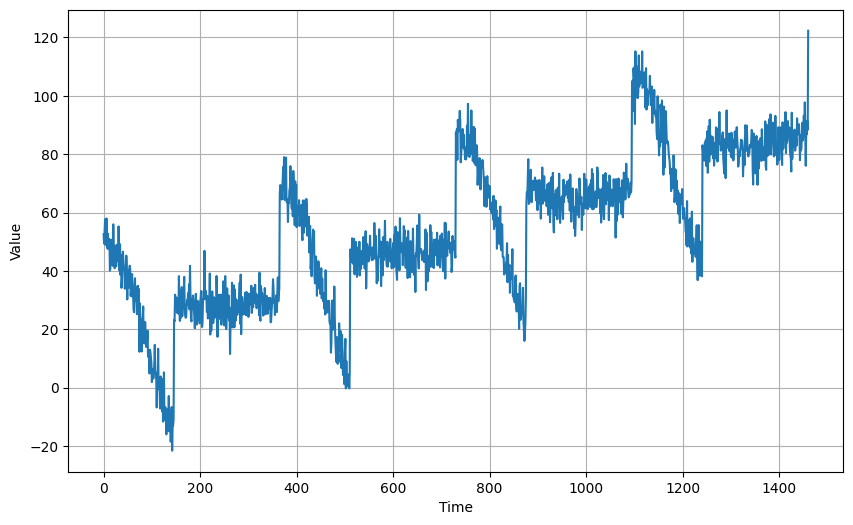

In [3]:
time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
amplitude = 40
slope = 0.05
noise_level = 5

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)

# Update with noise
series += noise(time, noise_level, seed=42)

# Plot the results
plot_series(time, series)

In [4]:
# Split the dataset
split_time = 1000

# Get the train set
time_train = time[:split_time]
x_train = series[:split_time]

# Get the validation set
time_valid = time[split_time:]
x_valid = series[split_time:]

In [5]:
# Parameters
window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

In [6]:
def windowed_dataset(series,window_size,batch_size,shuffle_buffer):
  # Generate a tf Dataset from the series values
  dataset = tf.data.Dataset.from_tensor_slices(series)

  # Window the data but only in specific size
  dataset = dataset.window(window_size + 1,shift = 1,drop_remainder = True)

  # Flatteh the window
  dataset = dataset.flat_map(lambda window : window.batch(window_size + 1))

  # Create tuples with features and labels
  dataset = dataset.map(lambda window : (window[:-1] , window[-1]))

  # Shuffle the windows
  dataset = dataset.shuffle(shuffle_buffer)

  # Create the batch of windows
  dataset = dataset.batch(batch_size).prefetch(1)

  return dataset

In [7]:
# Generate the dataset windows
dataset = windowed_dataset(x_train,window_size,batch_size,shuffle_buffer_size)

In [8]:
# Print the shapes of features and labels
for window in dataset.take(1):
  print("Shape of feature : ",window[0].shape)
  print("Shape of label   : ",window[1].shape)

Shape of feature :  (32, 20)
Shape of label   :  (32,)


In [9]:
# Build the model
model_tune = tf.keras.models.Sequential([
    tf.keras.layers.Lambda(lambda x : tf.expand_dims(x,axis = -1),
                           input_shape = [window_size]),
    tf.keras.layers.SimpleRNN(40,return_sequences = True),
    tf.keras.layers.SimpleRNN(40),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x : x * 100)
])

model_tune.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda (Lambda)             (None, 20, 1)             0         
                                                                 
 simple_rnn (SimpleRNN)      (None, 20, 40)            1680      
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 40)                3240      
                                                                 
 dense (Dense)               (None, 1)                 41        
                                                                 
 lambda_1 (Lambda)           (None, 1)                 0         
                                                                 
Total params: 4961 (19.38 KB)
Trainable params: 4961 (19.38 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [10]:
# Tune the learning rate
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch : 1e-8 * 10 ** (epoch/20)
)

# Initialize the optimizer
optimizer = tf.keras.optimizers.SGD(momentum = 0.9)

# Set the training parameters
model_tune.compile(
    loss = tf.keras.losses.Huber(),
    optimizer = optimizer
)

# Train the model
history = model_tune.fit(
    dataset,
    epochs = 100,
    callbacks = [lr_schedule]
)

Epoch 1/100
31/31 [==============================] - 2s 15ms/step - loss: 43.8304 - lr: 1.0000e-08
Epoch 2/100
31/31 [==============================] - 1s 12ms/step - loss: 41.3406 - lr: 1.1220e-08
Epoch 3/100
31/31 [==============================] - 1s 12ms/step - loss: 38.4011 - lr: 1.2589e-08
Epoch 4/100
31/31 [==============================] - 1s 22ms/step - loss: 35.3859 - lr: 1.4125e-08
Epoch 5/100
31/31 [==============================] - 1s 13ms/step - loss: 32.4659 - lr: 1.5849e-08
Epoch 6/100
31/31 [==============================] - 1s 10ms/step - loss: 29.8650 - lr: 1.7783e-08
Epoch 7/100
31/31 [==============================] - 1s 9ms/step - loss: 27.8138 - lr: 1.9953e-08
Epoch 8/100
31/31 [==============================] - 1s 14ms/step - loss: 26.2073 - lr: 2.2387e-08
Epoch 9/100
31/31 [==============================] - 1s 11ms/step - loss: 24.8686 - lr: 2.5119e-08
Epoch 10/100
31/31 [==============================] - 1s 16ms/step - loss: 23.7419 - lr: 2.8184e-08
Epoch 11/1

(1e-08, 0.001, 0.0, 50.0)

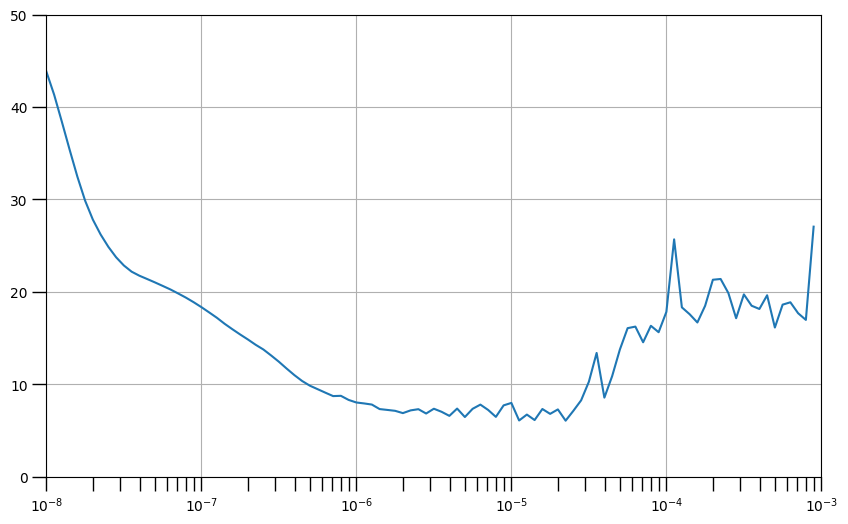

In [11]:
# Visualize the result and get the optimal learning rate
lrs = 1e-8 * (10 ** (np.arange(100)/20))

# Set the figure size
plt.figure(figsize = (10,6))

# Set the grid
plt.grid(True)

# Plot the loss in log scale
plt.semilogx(lrs,history.history['loss'])

# Increase the tickmarks size
plt.tick_params('both',length=10,width = 1,which = 'both')

# Set the plot boundaries
plt.axis([1e-8,1e-3,0,50])

(1e-07, 0.0001, 0.0, 20.0)

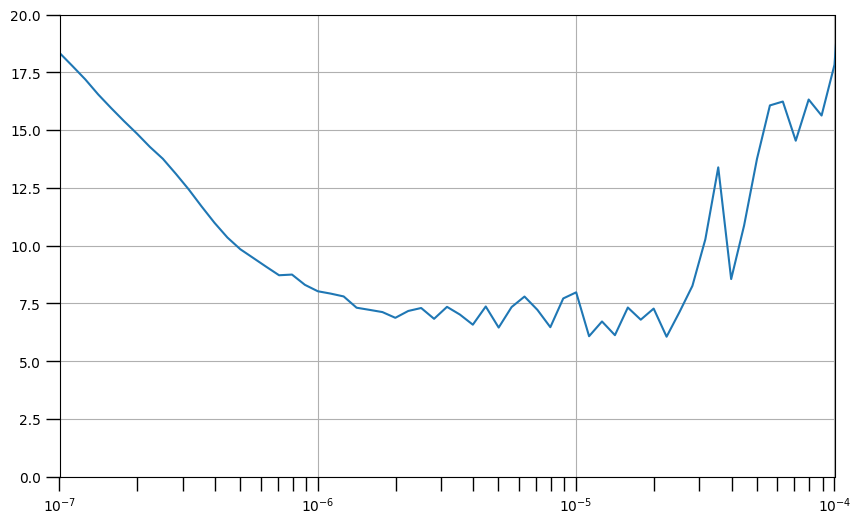

In [12]:
# Set the figure size
plt.figure(figsize=(10, 6))

# Set the grid
plt.grid(True)

# Plot the loss in log scale
plt.semilogx(lrs, history.history["loss"])

# Increase the tickmarks size
plt.tick_params('both', length=10, width=1, which='both')

# Set the plot boundaries
plt.axis([1e-7, 1e-4, 0, 20])

In [13]:
# Train the model
model = tf.keras.models.Sequential([
    tf.keras.layers.Lambda(lambda x : tf.expand_dims(x,axis = -1),
                           input_shape = [window_size]),
    tf.keras.layers.SimpleRNN(40,return_sequences = True),
    tf.keras.layers.SimpleRNN(40),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x : x*100)
])

# Set the learning rate
learning_rate = 1e-6

# Set the optimizer
optimizer = tf.keras.optimizers.SGD(
    learning_rate = learning_rate,
    momentum = 0.9
)

# Set the training parameters
model.compile(loss = tf.keras.losses.Huber(),
              optimizer = optimizer,
              metrics = ['mae'])

# Train the model
history = model.fit(dataset,epochs = 100)

Epoch 1/100
31/31 [==============================] - 2s 13ms/step - loss: 146.4887 - mae: 146.9887
Epoch 2/100
31/31 [==============================] - 1s 11ms/step - loss: 15.9265 - mae: 16.4219
Epoch 3/100
31/31 [==============================] - 0s 9ms/step - loss: 13.4158 - mae: 13.9077
Epoch 4/100
31/31 [==============================] - 0s 6ms/step - loss: 12.4188 - mae: 12.9110
Epoch 5/100
31/31 [==============================] - 0s 7ms/step - loss: 11.4949 - mae: 11.9869
Epoch 6/100
31/31 [==============================] - 1s 10ms/step - loss: 10.6150 - mae: 11.1068
Epoch 7/100
31/31 [==============================] - 0s 8ms/step - loss: 9.6190 - mae: 10.1066
Epoch 8/100
31/31 [==============================] - 1s 21ms/step - loss: 8.5695 - mae: 9.0535
Epoch 9/100
31/31 [==============================] - 1s 15ms/step - loss: 8.0614 - mae: 8.5478
Epoch 10/100
31/31 [==============================] - 0s 6ms/step - loss: 7.4189 - mae: 7.9035
Epoch 11/100
31/31 [===================

1/1 [==============================] - 0s 53ms/step


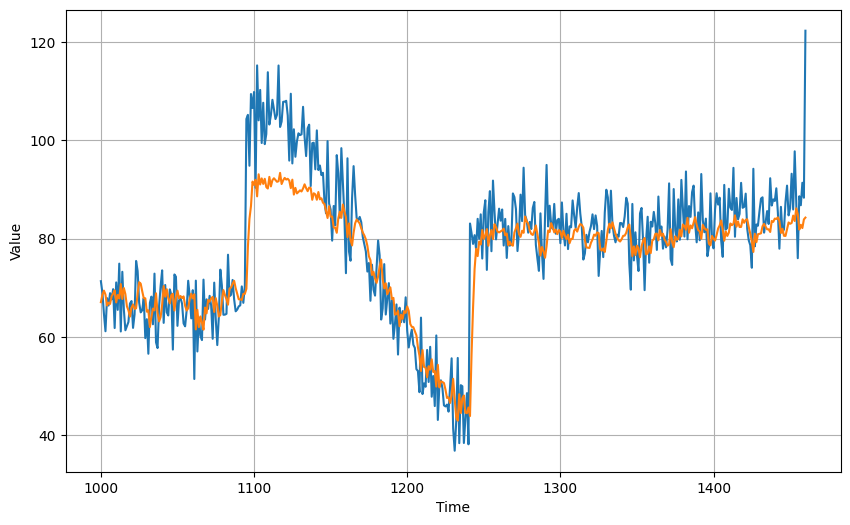

In [14]:
# Model prediction

# Initialize a list
forecast = []

# Reduce the original series
forecast_series = series[split_time - window_size : ]

# Use the model to predict data points per window size
for time in range(len(forecast_series) - window_size):
  forecast.append(model.predict(forecast_series[time : time + window_size][np.newaxis]))

# Convert to a numpy array and drop single dimensional axes
results = np.array(forecast).squeeze()

# Plot the results
plot_series(time_valid,(x_valid,results))

In [28]:
# Forecast in batches
def model_forecast(model,series,window_size,batch_size):
    dataset = tf.data.Dataset.from_tensor_slices(series)

    dataset = dataset.window(window_size,shift = 1,drop_remainder = True)

    dataset = dataset.flat_map(lambda window : window.batch(window_size))

    dataset = dataset.batch(batch_size).prefetch(1)

    forecast = model.predict(dataset)

    return forecast

15/15 [==============================] - 0s 5ms/step


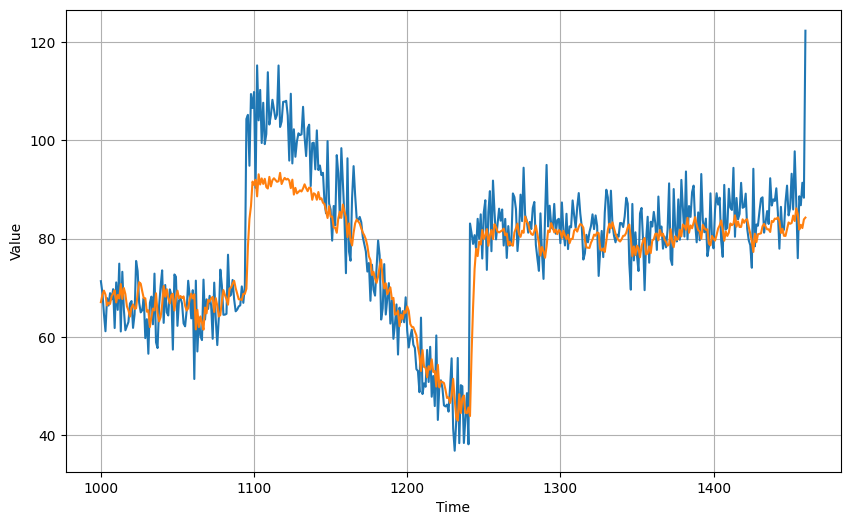

In [29]:
# Reduce the original series
forecast_series = series[split_time - window_size:-1]

# Use helper function to generate predictions
forecast = model_forecast(model, forecast_series, window_size, batch_size)

# Drop single dimensional axis
results = np.array(forecast).squeeze()

# Plot the results
plot_series(time_valid, (x_valid, results))

In [27]:
# Compute the MSE and MAE
print(tf.keras.metrics.mean_squared_error(x_valid, results).numpy())
print(tf.keras.metrics.mean_absolute_error(x_valid, results).numpy())

61.29302
5.7354517
